#  Описание проекта "Выбор локации для скважины"


Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap

Условия задачи:
•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
•	Бюджет на разработку скважин в регионе — 10 млрд рублей.
•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

План работы:
1.	Загрузка и подготовка данных. 
2.	Обучиние и проверка модель для каждого региона
3.	Подгоотовка к расчёту прибыли
4.	Расчёт прибыли по выбранным скважинам и предсказаниям модели 
5.	Расчёт рисков убытков и прибыли для каждого региона техникой boostrap
6.	Заключение. Итоговый вывод.


In [1]:
# установка 
!pip install phik -q

In [2]:
#необходимые импорты
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import plotly.express as pe
import os
import math
import phik
#Импорт кросвалидаторов и разбиения выборок
from sklearn.model_selection import (
                                     train_test_split,   
                                     RandomizedSearchCV,
                                     GridSearchCV   
                                    )
#Импорт модели лин регрессии и скалеров
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (
                                    #OneHotEncoder,
                                    #OrdinalEncoder, 
                                    StandardScaler, 
                                    MinMaxScaler,
                                    RobustScaler,     
                                    #LabelEncoder
                                    ) 
#Импорт метрик
from sklearn.metrics import (
                             mean_absolute_error,
                             r2_score,
                             mean_squared_error,
                             mean_squared_error,
                             #root_mean_squared_error     
                            )
from sklearn.compose import ColumnTransformer


#  класс pipeline
from sklearn.pipeline import Pipeline

#  импорты из phik 
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from IPython.core.display import display, HTML

from scipy import stats

In [3]:
#Константы проекта
RANDOM_STATE = 11

In [4]:
display(HTML("<style>.container { width:85% !important; }</style>"))

## Загрузка и подготовка данных

In [5]:
try:
    df_geo0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',',decimal='.')
    df_geo1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',',decimal='.') 
    df_geo2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',',decimal='.')
except:
    df_geo0 = pd.read_csv('geo_data_0.csv', sep=',',decimal='.')
    df_geo1 = pd.read_csv('geo_data_0.csv', sep=',',decimal='.')
    df_geo2 = pd.read_csv('geo_data_0.csv', sep=',',decimal='.')

In [6]:
#ф-ия ознакомления с данными
def data_primary_observe (df):
    pd.set_option('display.max_columns', None)
    if df.shape[0] <10:
        df_head = df.head()
    else:
        df_head = df.sample(10, random_state=5)
    display ('Несколько строк датафрейма:', df_head)
    display('*'*50)
    display ('Общая информация по датафрему:')
    df_info = df.info(verbose=None, buf=None, max_cols=None, memory_usage=None, show_counts=None, null_counts=None) #verbose=None, buf=None, max_cols=None, memory_usage=None, show_counts=None, null_counts=None)
    
    print('*'*50)
    #df_describe = df.describe()
    #df_hist = df.hist(figsize=(15, 20));
    #duplicate_quantity = 'Количество явных дубликатов = '+ str(df.duplicated().sum())+'\n' +'*'*50  #проверка наличия явных дубликатов
    #duplicate_quantity =' '.join(['Количество явных дубликатов =', str(df.duplicated().sum()), os.linesep, '*'*50])
    duplicate_quantity = 'Количество явных дубликатов = '+ str(df.duplicated().sum())
    return duplicate_quantity# display (df_head, df_info,  duplicate_quantity)

In [7]:
data_primary_observe(df_geo0)

'Несколько строк датафрейма:'

,id,f0,f1,f2,product
60743,2PZRL,1.200931,-0.009728,5.421251,119.220564
33949,EftqW,-0.224728,0.464427,6.166340,169.808150
52805,mvrCq,1.604950,-0.347809,-1.810252,131.589165
11804,9MUMY,1.667037,-0.370178,1.801218,144.585224
9229,f6XeG,0.236336,0.413279,2.643141,184.075418
49950,BY6bL,0.923732,-0.494178,5.661789,183.810016
24988,xyuNG,0.318241,0.988019,-0.919370,62.372404
90271,rvtB3,0.562133,0.736966,4.289078,162.268820
33532,qASEu,0.810089,-0.372344,5.396453,111.738444
88299,t1i5j,1.965978,0.067051,2.129362,145.620724


'**************************************************'

'Общая информация по датафрему:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
**************************************************


'Количество явных дубликатов = 0'

In [8]:
data_primary_observe(df_geo1)

'Несколько строк датафрейма:'

,id,f0,f1,f2,product
60743,55YGN,9.659465,1.925571,2.997100,80.859783
33949,XTCns,13.384364,-4.139606,2.000782,53.906522
52805,HBvFe,-11.443927,-15.305820,0.004070,3.179103
11804,bU5W3,8.140928,-1.978514,3.996930,107.813044
9229,Ou1hR,4.895941,-5.586120,3.003143,80.859783
49950,9fwrS,-3.622069,-5.642445,5.002268,137.945408
24988,XCTTg,1.852176,-17.711929,3.992627,110.992147
90271,YSQof,-6.399776,5.788733,2.003555,57.085625
33532,ndvjG,-1.980070,-2.234584,2.002621,57.085625
88299,pq1tO,0.534363,-11.378929,4.007568,110.992147


'**************************************************'

'Общая информация по датафрему:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
**************************************************


'Количество явных дубликатов = 0'

In [13]:
df_geo0.id.value_counts().head(11)

TtcGQ    2
HZww2    2
bxg6G    2
bsk9y    2
QcMuo    2
AGS9W    2
74z30    2
fiKDv    2
Tdehs    2
A5aEY    2
OCc3X    1
Name: id, dtype: int64

In [14]:
#провека содержимого дубликатов id
df_geo0.query("id =='bxg6G'")

,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


In [15]:
'*'*50

'**************************************************'

In [16]:
data_primary_observe(df_geo2)

'Несколько строк датафрейма:'

,id,f0,f1,f2,product
60743,MfutT,-1.543398,3.813586,1.373221,186.714538
33949,eOQ8l,1.109355,0.633716,6.672054,73.641755
52805,ypKp8,-0.060376,0.412236,3.091167,125.190694
11804,BY6hU,1.013932,1.935433,5.955320,130.826729
9229,Chd1j,-0.339970,1.707540,-4.540219,14.983400
49950,34ot3,-1.664126,0.749064,-0.158524,86.041575
24988,YFLPw,1.131890,3.956327,5.348871,141.952081
90271,3gq8u,-0.288479,-3.324516,3.060588,86.587048
33532,Tr0eY,-1.324149,-3.687472,-1.224732,127.494674
88299,zyVLo,0.250471,2.163133,0.268589,29.390829


'**************************************************'

'Общая информация по датафрему:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
**************************************************


'Количество явных дубликатов = 0'

**Подитог:** данные без пропусков, типы данных корректны, именование колонок в порядке, датасеты содержат по 100 тыс записей. Датасеты содержат равное количество входных признаков. По не понятным причинам есть дубликаты в колонке id: в geo0 - 10шт и по 4 в остальных.

### Исследовательский анализ

In [17]:
#ф-ия обзора вещественных признаков
def hist_with_stat_lines(df, df_col, dtitle, dxlabel, dylabel, bins = 0, kde=False):
    df_col_description =  df_col.describe()
    mean = df_col_description[1]
    std = df_col_description[2]
    df_min = df_col_description[3]
    q1 = df_col_description[4]
    median = df_col_description[5]
    q3 = df_col_description[6]
    df_max = df_col_description[7]
    iqr = (q3-q1)+0.1 
    left_border = q1 - iqr*1.5
    # усы обрезаются минимальным и максимальным значением параметра сооветственно
    if left_border < df_min:
        left_border = df_min
    right_border = q3 + iqr*1.5
    if right_border > df_max:
        right_border = df_max
        
    if bins == 0:
        bins = right_border - left_border
        if bins>100:
            bins = 100
        elif bins<1:
            bins = bins*20
        elif bins>1 and bins<5:
            bins = 5
        bins = int(bins)
    else:
        bins = bins
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,12))
    fig.suptitle(dtitle)   
    fig = sns.histplot(df, x=df_col, bins=bins, kde=kde, ax=axes[0]  ) # binwidth = bins/10 #kde=True  edgecolor='g' bins=bins  binwidth = bins/50
    axes[0].set_title('Гистограмма распределения')
    fig.set(xlim=(left_border, right_border)) 
    ax = sns.boxplot(x=df_col, data=df, ax=axes[1])
    ax = sns.stripplot(x=df_col, data=df, color="orange", jitter=0.2, size=2.5, ax=axes[1])
    axes[1].set_title('"Ящик с усами +"')
    #plt.title(dtitle)
    #plt.xlabel(dxlabel)
    axes[0].set_ylabel(dylabel)
    axes[0].set_xlabel(dxlabel)
    axes[1].set_xlabel(dxlabel)
    #axes[0].set.
    #plt.ylabel(dylabel)
    #fig.supxlabel(dxlabel)
    axes[0].axvline(x=mean,linewidth=1, color='r', linestyle='-' , label= 'mean_value')
    axes[0].axvline(x=median,linewidth=1, color='b', linestyle='-', label= 'median_value')
    axes[0].axvline(x=q1,linewidth=1, color='g', linestyle='--',label= 'Q1_value')
    axes[0].axvline(x=q3,linewidth=1, color='g', linestyle='--',label= 'Q3_value')
    #plt.legend(loc = 'best')
    axes[0].legend(loc = 'best')
    #fig.suptitle(dtitle, fontsize = 13) ;
    return print ('Статистические параметры колонки данных' ,dxlabel,'\n' ,'\n',  df_col_description,'\n')# df_col_description


Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64 



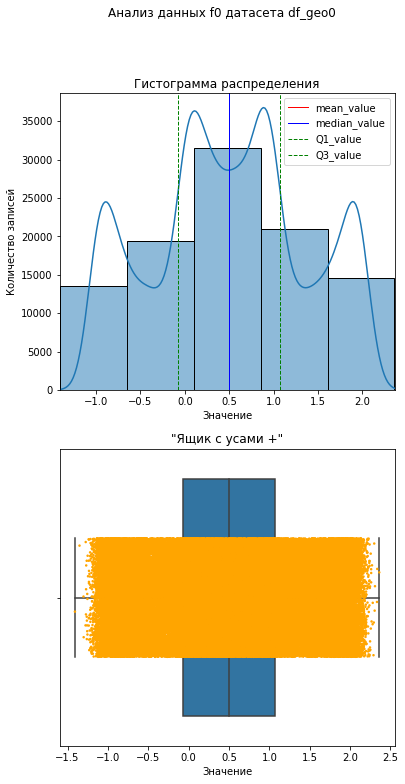

In [18]:
hist_with_stat_lines(df_geo0, df_geo0['f0'], 
                     'Анализ данных f0 датасета df_geo0', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64 



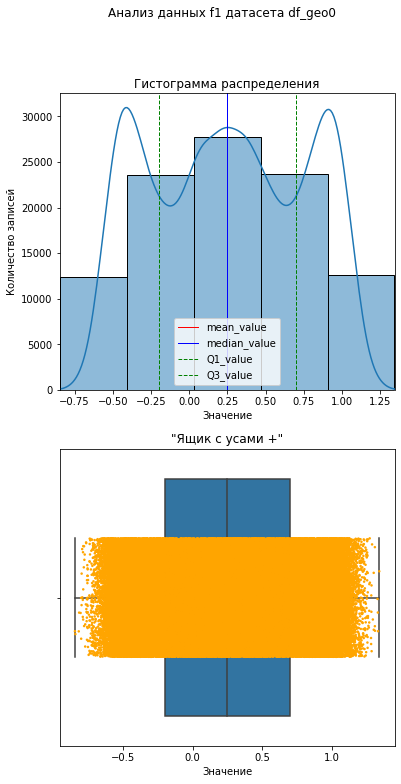

In [19]:
hist_with_stat_lines(df_geo0, df_geo0['f1'], 
                     'Анализ данных f1 датасета df_geo0', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64 



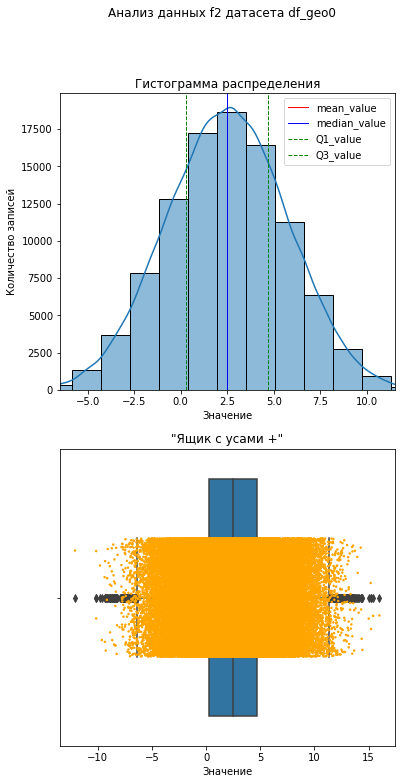

In [20]:
hist_with_stat_lines(df_geo0, df_geo0['f2'], 
                     'Анализ данных f2 датасета df_geo0', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64 



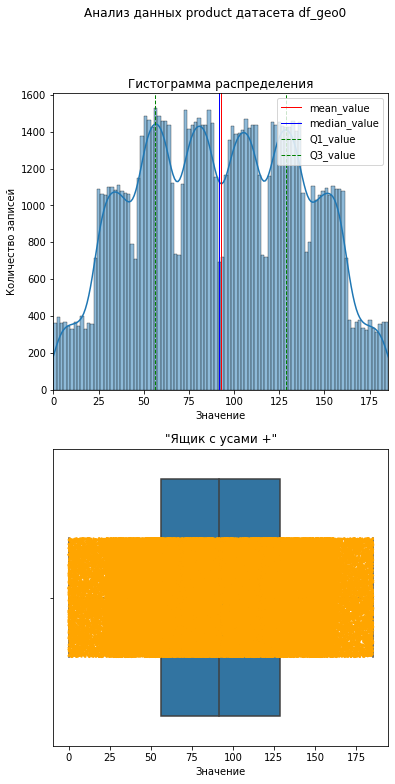

In [21]:
hist_with_stat_lines(df_geo0, df_geo0['product'], 
                     'Анализ данных product датасета df_geo0', 
                     'Значение',
                     'Количество записей',0,True)

**Подитог по исследовательскому анализу данныз датасета df_geo0**
Параметры f0 и f1 демонстрируют  нормальное распределение, подозрений на выбросы нет.
Параметр f2 тоже распеределен близко к нормальному, есть значения выходящие за рамки "нормального разброса"
Но не понимая, что за параметрт пока не рискну чистить от выбросов. Возможно я не прав...
Значение целевой функции имеет много модальное распределение, подозрений на выборосы нет.

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64 



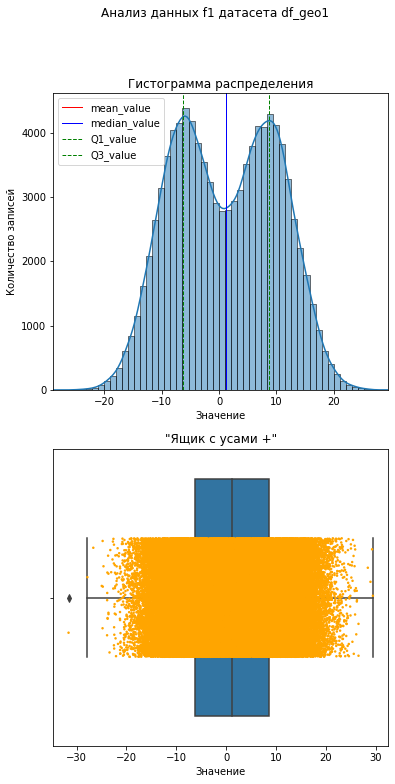

In [22]:
#Рассмотрим данные датасета df_geo1
hist_with_stat_lines(df_geo1, df_geo1['f0'], 
                     'Анализ данных f1 датасета df_geo1', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64 



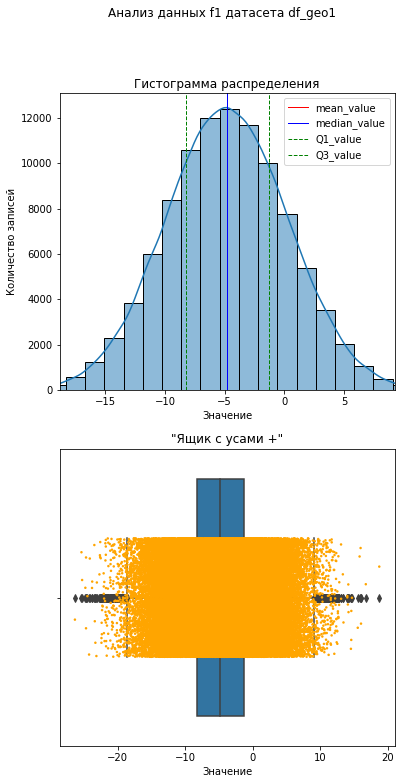

In [23]:
hist_with_stat_lines(df_geo1, df_geo1['f1'], 
                     'Анализ данных f1 датасета df_geo1', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64 



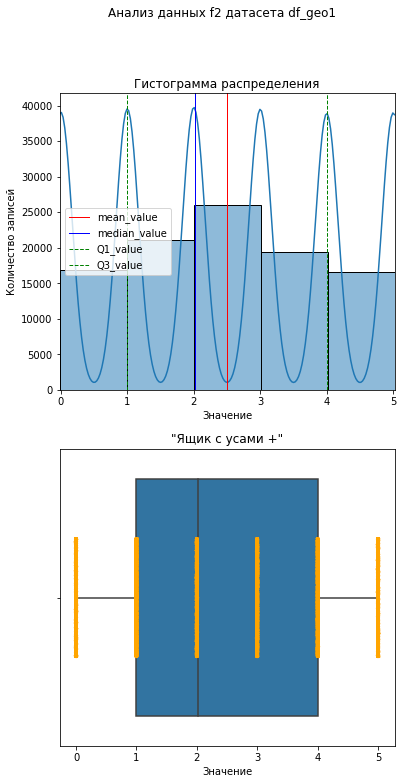

In [24]:
hist_with_stat_lines(df_geo1, df_geo1['f2'], 
                     'Анализ данных f2 датасета df_geo1', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64 



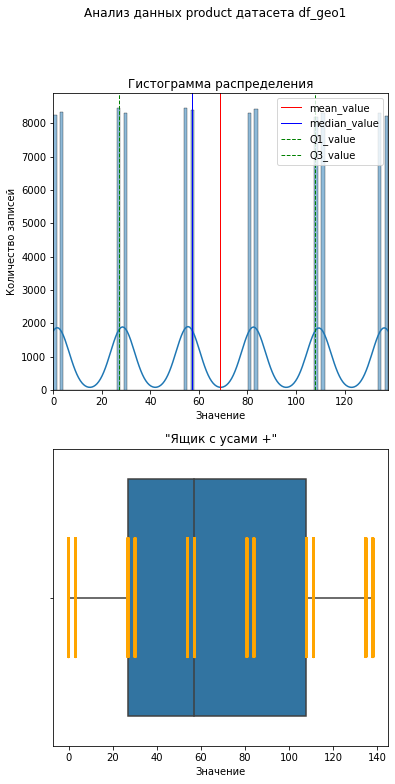

In [25]:
hist_with_stat_lines(df_geo1, df_geo1['product'], 
                     'Анализ данных product датасета df_geo1', 
                     'Значение',
                     'Количество записей',0,True)

**Подитог по исследовательскому анализу данныз датасета df_geo1**
- Параметр f0 распределен бимодально. есть подозрение на выброс.
- Параметр f1 распределен нормально, есть подозрения на выбросы,не понимая, что за параметрт пока не рискну чистить от выбросов. Возможно я не прав...
- Параметр f2 распределен дискретно кластерно, без подозрений на выбросы
- Целевая функция product выглядит похоже - кластерное распределение, без выюросов. 
 

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64 



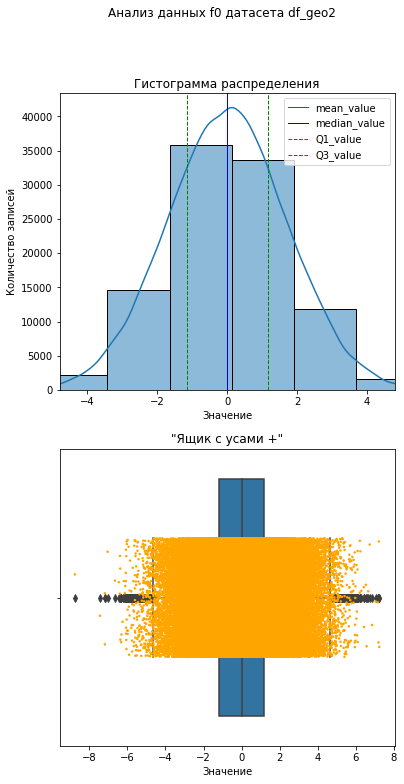

In [26]:
# Рассмотрим заключительный затасет df_geo2
hist_with_stat_lines(df_geo2, df_geo2['f0'], 
                     'Анализ данных f0 датасета df_geo2', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64 



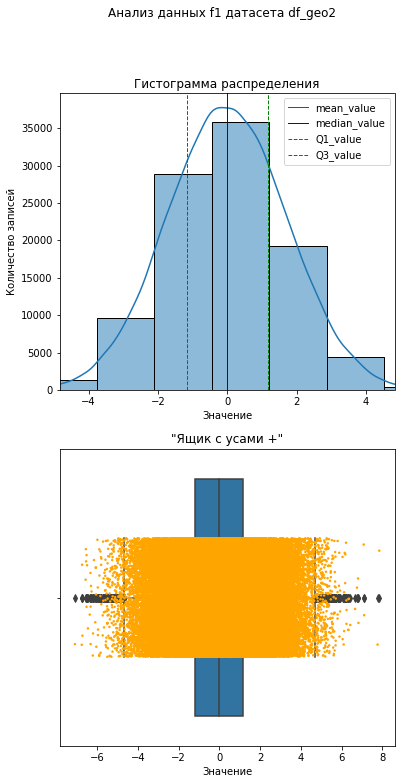

In [27]:
# Рассмотрим заключительный затасет df_geo2
hist_with_stat_lines(df_geo2, df_geo2['f1'], 
                     'Анализ данных f1 датасета df_geo2', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64 



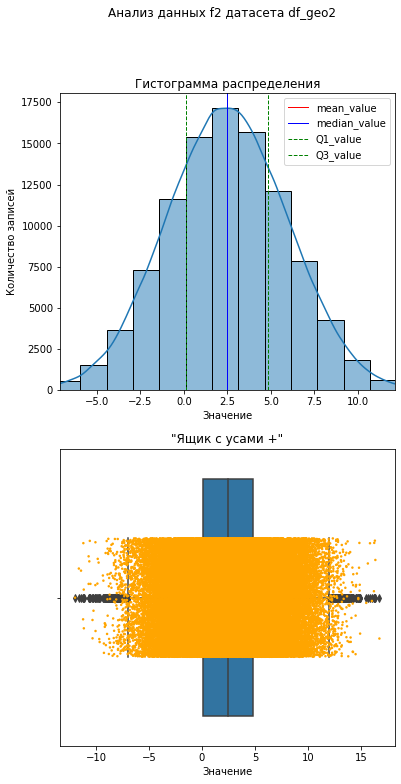

In [28]:
# Рассмотрим заключительный затасет df_geo2
hist_with_stat_lines(df_geo2, df_geo2['f2'], 
                     'Анализ данных f2 датасета df_geo2', 
                     'Значение',
                     'Количество записей',0,True)

Статистические параметры колонки данных Значение 
 
 count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64 



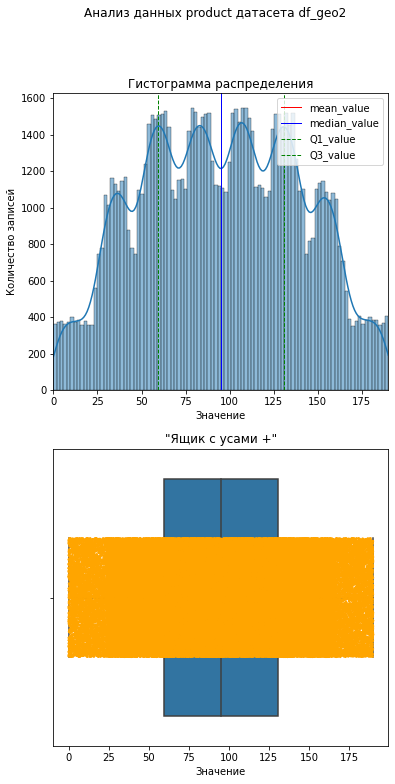

In [29]:
# Рассмотрим заключительный затасет df_geo2
hist_with_stat_lines(df_geo2, df_geo2['product'], 
                     'Анализ данных product датасета df_geo2', 
                     'Значение',
                     'Количество записей',0,True)

**Подитог по исследовательскому анализу данныз датасета df_geo2**
- Параметры f0 и f1 распределены близко к нормальному. есть подозрения на выбросы не понимая, что за параметрт пока не рискну чистить от выбросов. Возможно я не прав...
- Параметр f2 распределен нормально, есть подозрения на выбросы.
- Целевая функция product - многомодальное распределение, без выбросов. 

### Анализ корреляций. Проверка на мультиколлинеарность.

In [30]:
interval_cols = ['f0', 'f1','f2', 'product']

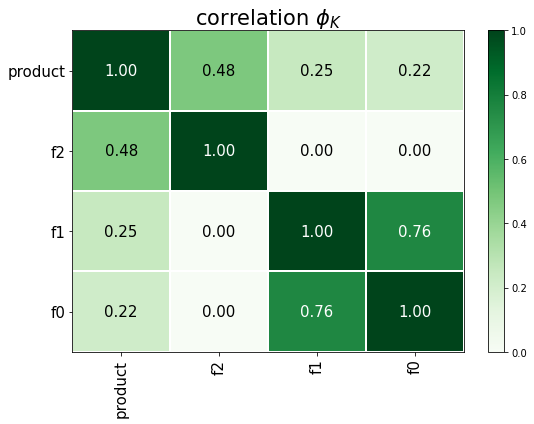

In [31]:
#перейдем к анализу корреляций в df_geo0, но id удалим
df_geo0_=df_geo0.drop('id',  axis=1 )
#посмотрим на матрицу корреляций, нет ли мультиколлинеарности

phik_overview = phik_matrix(df_geo0_, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
)

In [104]:
#df_geo0_tmp = df_geo0[df_geo0.index % 10 == 0]  

In [105]:
#for i in ('f0','f1','f2' ):
#    title = "Диаграмма рессеяния целевой функции по значениям "+str(i)
#    fig = pe.scatter(df_geo0_tmp, x=i, y="product",  title=title)
#    fig.show()

**Подитог по df_geo0**  коэфф. кор с целевым признаком f0=0.22, f1=0.25, d2=0.48. 
Мультиколлинеарность не обнаруживается.

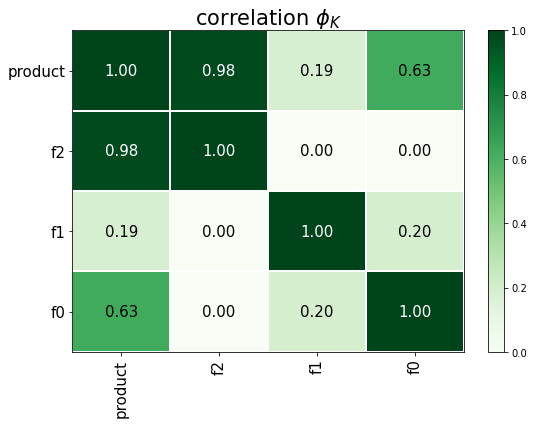

In [69]:
#перейдем к анализу корреляций в df_geo1, но id удалим
df_geo1_=df_geo1.drop('id',  axis=1 )
#посмотрим на матрицу корреляций, нет ли мультиколлинеарности

phik_overview = phik_matrix(df_geo1_, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
)

**Подитог по df_geo1** коэфф. кор с целевым признаком f0=0.63, f1=0.19, d2=0.98. 
Мультиколлинеарность не обнаруживается.

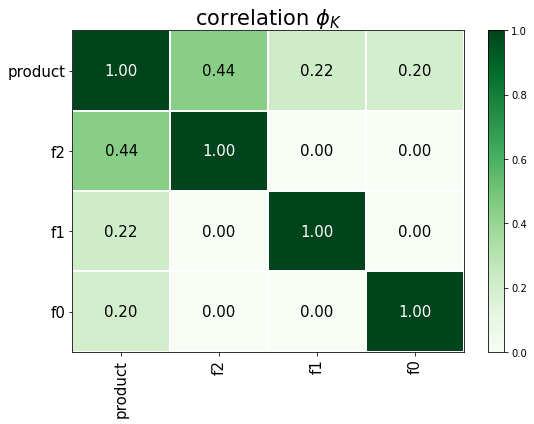

In [70]:
#перейдем к анализу корреляций в df_geo2, но id удалим
df_geo2_=df_geo2.drop('id',  axis=1 )
#посмотрим на матрицу корреляций, нет ли мультиколлинеарности

phik_overview = phik_matrix(df_geo2_, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(8, 6)
)

**Подитог по df_geo2** коэфф. кор с целевым признаком f0=0.2, f1=0.22, d2=0.44. 
Мультиколлинеарность не обнаруживается.

### Итог по исследовательскому анализу
-  **по датасету df_geo0** 
- Параметры f0 и f1 демонстрируют нормальное распределение, подозрений на выбросы нет. 
- Параметр f2 тоже распеределен близко к нормальному, есть значения выходящие за рамки "нормального разброса" 
- Значения целевой функции имеет много модальное распределение, подозрений на выборосы нет.
- Коэфф. кор с целевым признаком f0=0.22, f1=0.25, d2=0.48. 
- Мультиколлинеарность не обнаруживается.

-  **по датасету df_geo1** 
- Параметр f0 распределен бимодально. есть подозрение на выброс.
- Параметр f1 распределен нормально, есть подозрения на выбросы.
- Параметр f2 распределен дискретно кластерно, без подозрений на выбросы
- Целевая функция product выглядит похоже - кластерное распределение, без выюросов. 
- Коэфф. кор с целевым признаком f0=0.63, f1=0.19, d2=0.98. 
- Мультиколлинеарность не обнаруживается.

-  **по датасету df_geo2** 
- Параметры f0 и f1 распределены близко к нормальному. есть подозрения на выбросы 
- Параметр f2 распределен нормально, есть подозрения на выбросы.
- Целевая функция product - многомодальное распределение, без выбросов. 
- Коэфф. кор с целевым признаком f0=0.2, f1=0.22, d2=0.44. 
- Мультиколлинеарность не обнаруживается.

Данные гоотовы для разбиения и обучения моделей.

## Обучение и проверка модели

### Разбиение данных на тренировочную и валидационную выборки

In [71]:
#Ф-ия разбиения данных
def DataSplit (df, target):
    
    # сохранение входных признаков в переменную X
    #X = df
    X = df.drop('product'  , axis=1) # id не удаляется чтобы была возможность\
    #в итоговом валидацтонном датасете его использовать для отбора лучших точек и их идентификаторов. 
    
    # сохранение целевого признака в переменную y
    y = target
    # разделение на тренировочную и тестовую выборки
    
    X_train, X_val, y_train, y_val = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,
        test_size=0.25
        #stratify=stratify
    ) 
    return X_train, X_val, y_train, y_val


In [72]:
X_train0, X_val0, y_train0, y_val0 = DataSplit (df_geo0,  
                                                df_geo0['product']                                          
                                               )

### Обучение модели и  предсказания на валидационной выборке
Для этого буду использовать PipeLine

In [73]:
num_cols = ['f0', 'f1','f2']
data_preprocessor = ColumnTransformer(
        [
            ('num', StandardScaler(), num_cols)
        ], 
        remainder='passthrough'
        #remainder='drop'
    )

pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression() )
        ]
        
    )

In [74]:
#создадим сетку для подбора пераметров  моделей и сравнения скалеров.

parameters = [
  
    # словарь для модели LogisticRegression()
      {
        'models': [LinearRegression(  )],
        'models__normalize' :[True, False],
        'models__fit_intercept' :[True, False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  RobustScaler(), 'passthrough']              
        
    },

]

#'''
#oscv = OptunaSearchCV(
#    pipe_final,
#    parameters,
#    cv=5,
#    n_trials=20,
#    scoring='roc_auc',
#    random_state=RANDOM_STATE
#)
#'''

#randomized_search = RandomizedSearchCV(
grid_search = GridSearchCV(
    pipe_final, 
    parameters, 
    cv=5,
    #scoring='r2',
    #scoring='neg_median_absolute_error',#mae
    scoring='neg_root_mean_squared_error',
    #random_state=RANDOM_STATE,
    n_jobs = -1
)

X_train0_ = X_train0.drop('id' , axis=1) #только наэтом этапе удадяется id, чтобы модель посчитала.
grid_search.fit(X_train0_, y_train0)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression(normalize=True))])
Метрика лучшей модели на тренировочной выборке: -37.65043511183294


In [75]:
result = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_colwidth', None)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

    rank_test_score                      param_models  mean_test_score  \
0                 1  LinearRegression(normalize=True)       -37.650435   
1                 1  LinearRegression(normalize=True)       -37.650435   
2                 1  LinearRegression(normalize=True)       -37.650435   
3                 1  LinearRegression(normalize=True)       -37.650435   
4                 1  LinearRegression(normalize=True)       -37.650435   
5                 1  LinearRegression(normalize=True)       -37.650435   
6                 1  LinearRegression(normalize=True)       -37.650435   
7                 1  LinearRegression(normalize=True)       -37.650435   
9                 9  LinearRegression(normalize=True)       -37.775133   
13                9  LinearRegression(normalize=True)       -37.775133   
11               11  LinearRegression(normalize=True)       -60.925841   
15               11  LinearRegression(normalize=True)       -60.925841   
8                13  LinearRegression(

 типы масштабирования на метрику не повлияли.....

In [76]:
#рассчитаем метрику на валидационной выборке
X_val0_ = X_val0.drop('id' , axis=1)
y_pred = grid_search.best_estimator_.predict(X_val0_)
#print ("mean_squared_error на валидационной:",  mean_squared_error(y_val, y_pred))
RMSE = mean_squared_error(y_val0, y_pred, squared=False)
print ("RMSE на валидационной выборке по региону geo0:", RMSE  )

RMSE на валидационной выборке по региону geo0: 37.819665926421706


### Сохранение предсказанных и правильных ответов на валидационной выборке

In [77]:
#Добавим данные прогноза к валидационной выборке.
X_val0['forecast_product'] = y_pred
X_val0['true_product'] = y_val0

In [78]:
#Посмотрим на стат параметры датасета
X_val0.describe()

,f0,f1,f2,forecast_product,true_product
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.507475,0.246060,2.472698,92.400724,92.341886
std,0.869780,0.503502,3.249304,23.380538,44.169944
min,-1.253978,-0.820561,-12.088328,-10.348235,0.004022
25%,-0.058655,-0.205073,0.270043,76.437139,56.322243
50%,0.515689,0.247773,2.493766,92.710684,91.071641
75%,1.074888,0.691678,4.690583,108.341591,128.216649
max,2.337080,1.343769,15.230322,185.797390,185.352015


### Вывод  на экран среднего предсказанного  запаса сырья и RMSE модели.

In [79]:
print ("RMSE на валидационной выборке по региону geo0:", RMSE  )
print ("Средний предсказанный запас:", X_val0.forecast_product.mean()  )
# расширим информативность
print ("Суммарный предсказанный запас по региону geo0:", X_val0.forecast_product.sum())
print ("Суммарный фактический запас по региону geo0:", X_val0.true_product.sum())


RMSE на валидационной выборке по региону geo0: 37.819665926421706
Средний предсказанный запас: 92.4007244058271
Суммарный предсказанный запас по региону geo0: 2310018.110145678
Суммарный фактический запас по региону geo0: 2308547.155072037


**Подитог подбора модели для региона geo0** 
- На тренировочной выборке получена метрика RMSE 37.65, на валидационной 37.81.
- В валидационный датасет X_val0 добавлены прогнозные расчеты по запасам.
- Средний предсказанный запас: 92.4007244058271
- Суммарный предсказанный запас по региону geo0: 2310028.4583808705
- Суммарный фактический запас по региону geo0: 2308547.155072037
- Прогнозный и фактический запасы сопоставимы.

- По среднему и медиане оччень близко. А вот что получатся отрицательный запас это надо поправить я думаю.

In [80]:
X_val0['forecast_product'] =np.where(X_val0['forecast_product'] < 0,0, X_val0['forecast_product'])
                                     

**проделаем подобные шаги для df_geo1 и df_geo2**

In [81]:
#рарбиение датасета
X_train1, X_val1, y_train1, y_val1 = DataSplit (df_geo1,  
                                                df_geo1['product']                                          
                                               )

In [82]:
#подбор модели
X_train1_ = X_train1.drop('id' , axis=1)
grid_search.fit(X_train1_, y_train1)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression(normalize=True))])
Метрика лучшей модели на тренировочной выборке: -0.8910658245059248


In [83]:
#рассчитаем метрику на валидационной выборке
X_val1_ = X_val1.drop('id' , axis=1)
y_pred = grid_search.best_estimator_.predict(X_val1_)
RMSE = mean_squared_error(y_val1, y_pred, squared=False)
print ("RMSE на валидационной выборке по региону geo1:", RMSE  )

RMSE на валидационной выборке по региону geo1: 0.888431808565045


**Очень хорошо посчитала модель этот реион**

In [84]:
#Добавим данные прогноза к валидационной выборке.
X_val1['forecast_product'] = y_pred
X_val1['true_product'] = y_val1
#Стат параметры по geo1
X_val1.describe()

,f0,f1,f2,forecast_product,true_product
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,1.154614,-4.819403,2.491257,68.737206,68.728582
std,8.985484,5.124898,1.708140,46.057735,46.067942
min,-27.829616,-24.712023,-0.017686,-1.911231,0.000000
25%,-6.315715,-8.319029,0.999934,28.517962,26.953261
50%,1.205697,-4.827859,2.010461,57.811932,57.085625
75%,8.646820,-1.313632,4.000068,109.365310,107.813044
max,26.531697,15.965151,5.016247,139.700873,137.945408


In [85]:
# тоже почистим от отрицательных запасов
X_val1['forecast_product'] =np.where(X_val1['forecast_product'] < 0,0, X_val1['forecast_product'])

In [86]:
print ("RMSE на валидационной выборке по региону geo1:", RMSE  )
print ("Средний предсказанный запас по региону geo1:", X_val1.forecast_product.mean())
print ("Суммарный предсказанный запас по региону geo1:", X_val1.forecast_product.sum())
print ("Суммарный фактический запас по региону geo1:", X_val1.true_product.sum())

RMSE на валидационной выборке по региону geo1: 0.888431808565045
Средний предсказанный запас по региону geo1: 68.74722617608553
Суммарный предсказанный запас по региону geo1: 1718680.6544021382
Суммарный фактический запас по региону geo1: 1718214.549132672


**Подитог подбора модели для региона geo1** 
- На тренировочной выборке получена мметрика RMSE 0.89, на валидационной 0.88.
- В валидационный датасет X_val1 добавлены прогнозные расчеты по запасам.
- Средний предсказанный запас по региону geo1: 68.74722617608553
- Суммарный предсказанный запас по региону geo1: 1718680.6544021382
- Суммарный фактический запас по региону geo1: 1718214.549132672
- Прогнозный и фактический запасы сопоставимы.

In [87]:
##по региону geo2
#разобьем данные 
X_train2, X_val2, y_train2, y_val2 = DataSplit (df_geo2,
                                                df_geo2['product']                                          
                                               )

In [88]:
#Отберем модель
X_train2_ = X_train2.drop('id' , axis=1)
grid_search.fit(X_train2_, y_train2)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression(normalize=True))])
Метрика лучшей модели на тренировочной выборке: -40.07578295882634


In [89]:
#рассчитаем метрику на валидационной выборке
X_val2_ = X_val2.drop('id' , axis=1)
y_pred = grid_search.best_estimator_.predict(X_val2_)
RMSE = mean_squared_error(y_val2, y_pred, squared=False)
print ("RMSE на валидационной выборке по региону geo2:", RMSE  )

RMSE на валидационной выборке по региону geo2: 40.000510543385026


In [90]:
#Добавим данные прогноза к валидационной выборке.
X_val2['forecast_product'] = y_pred
X_val2['true_product'] = y_val2
#Стат параметры по geo1
X_val2.describe()

,f0,f1,f2,forecast_product,true_product
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.005990,-0.018128,2.489922,95.022729,94.818311
std,1.716411,1.729717,3.486893,20.030803,44.731088
min,-7.185810,-6.714372,-11.970335,12.044997,0.004606
25%,-1.152523,-1.195034,0.131521,81.450857,59.399446
50%,0.013924,-0.025708,2.483013,94.971246,94.927429
75%,1.158326,1.154012,4.862136,108.613848,130.281414
max,7.215527,6.238339,16.739402,176.730793,190.011722


In [91]:
print ("RMSE на валидационной выборке по региону geo2:", RMSE  )
print ("Средний предсказанный запас по региону geo2:", X_val2.forecast_product.mean()  )
print ("Суммарный предсказанный запас по региону geo2:", X_val2.forecast_product.sum())
print ("Суммарный фактический запас по региону geo2:", X_val2.true_product.sum())

RMSE на валидационной выборке по региону geo2: 40.000510543385026
Средний предсказанный запас по региону geo2: 95.02272926228342
Суммарный предсказанный запас по региону geo2: 2375568.2315570856
Суммарный фактический запас по региону geo2: 2370457.778985383


**Подитог по региону geo2**
- На тренировочной выборке получена мметрика RMSE 40.07, на валидационной 40.00.
- В валидационный датасет X_val2 добавлены прогнозные расчеты по запасам.
- Средний предсказанный запас по региону geo2: 95.02272926228342
- Суммарный предсказанный запас по региону geo2: 2375568.2315570856
- Суммарный фактический запас по региону geo2: 2370457.778985383
- Прогнозный и фактический запасы сопоставимы.

### Итог по разделу.

- Для каждого региона был запущен процесс кроссвалиации с подбором гиперпараметров модели и поиска лучшего скалера при помощи инструмента GridSearchCV.
- В результате методом  grid_search.best_estimator_.predict предсказаны запасы по регионам, которые добавлены в валидационные выборки.
- Наилучшая качество работы по RMSE на валидационной выбрке показано по региону geo1: 0.88, далее geo0 - 37.81, в конце geo2 c 40.00

-В валидационные датасеты регионов добавлены данные о прогнозируемых запасах

- Средний предсказанный запаспо региону geo0: 92.4007244058271
- Суммарный предсказанный запас по региону geo0: 2310018.110145678
- Суммарный фактический запас по региону geo0: 2308547.155072037

- Средний предсказанный запас по региону geo1: 68.74722617608553
- Суммарный предсказанный запас по региону geo1: 1718680.6544021382
- Суммарный фактический запас по региону geo1: 1718214.549132672

- Средний предсказанный запас по региону geo2: 95.02272926228342
- Суммарный предсказанный запас по региону geo2: 2375568.2315570856
- Суммарный фактический запас по региону geo2: 2370457.778985383

Итоговые запасы фактические и предсказанные для всех датасетов сопоставимы.

## Подготовка к расчёту прибыли

### Cохранение в отдельных переменных всеx ключевыех значения для расчётов 

In [92]:
POINTS = 500 #При разведке региона исследуют 500 точек(как я понял это количество нужно в функции bootstrap)
TOP_POINTS = 200 # из которых с помощью машинного обучения выбирают 200 лучших для разработки
BUDGET_PER_REGION = 10000000000 #бюджет на регион
BAREL_COST = 450 # 450 000 за еденицу product
COST_OF_ONE_PRODUCT =  450000

### Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. Сравнение полученного объёма сырья со средним запасом в каждом регионе.

In [93]:
#Разделим бюджет на best_points получим бюджет  на одну точку
budget_per_point = BUDGET_PER_REGION/TOP_POINTS
#разделим budget_per_point на цену еденицы добычи чтобы определить минимальный запас.
minimal_product = budget_per_point/COST_OF_ONE_PRODUCT
print ('Минимальный запас в точке с которого целесообразно начинать добычу:', minimal_product)

Минимальный запас в точке с которого целесообразно начинать добычу: 111.11111111111111


In [94]:
##Сравнение со средними по регионам
print ('Разница между средним запасом по региону geo0 и безубыточным минимальным запасом  : ',
        X_val0.forecast_product.mean() - minimal_product  )
print ('Разница между средним запасом по региону geo1 и безубыточным минимальным запасом : ',
       X_val1.forecast_product.mean() - minimal_product )
print ('Разница между средним запасом по региону geo2 и безубыточным минимальным запасом : ',
       X_val2.forecast_product.mean() - minimal_product)

Разница между средним запасом по региону geo0 и безубыточным минимальным запасом  :  -18.709972775876295
Разница между средним запасом по региону geo0 и безубыточным минимальным запасом :  -42.36388493502558
Разница между средним запасом по региону geo0 и безубыточным минимальным запасом :  -16.088381848827694


Средние не дотягивают нигде. Отберем 200 лучших точек

In [95]:
X_val0_sorted = X_val0.sort_values('forecast_product', ascending = False)
X_val0_sorted['above_minimal_product'] = X_val0_sorted['forecast_product'] - minimal_product
#вот наши лучшие точки
X_val0_sorted_best_point = X_val0_sorted.iloc[:200]
#проверим
X_val0_sorted_best_point.tail(5)

,id,f0,f1,f2,forecast_product,true_product,above_minimal_product
49997,rQlAc,0.836589,-0.501398,8.975063,147.482098,171.610462,36.370987
28147,q24pj,-0.917653,-0.207433,10.596502,147.476542,143.811663,36.365431
91277,wBKWi,0.935121,-0.541743,8.830544,147.468614,168.941265,36.357503
18345,z5ayU,0.073917,0.257862,11.037293,147.455807,175.465480,36.344696
21145,seUba,1.099544,-0.622548,8.552646,147.395092,153.500785,36.283981


In [96]:
#сделаем тоже самое для регионо geo1 и geo2
X_val1_sorted = X_val1.sort_values('forecast_product', ascending = False)
X_val1_sorted['above_minimal_product'] = X_val1_sorted['forecast_product'] - minimal_product
#вот наши лучшие точки
X_val1_sorted_best_point = X_val1_sorted.iloc[:200]
#проверим
X_val1_sorted_best_point.tail(5)

,id,f0,f1,f2,forecast_product,true_product,above_minimal_product
46612,0WGhR,-13.708950,-2.622273,4.998175,138.409497,137.945408,27.298386
23931,5ZXbB,-11.718797,-7.632441,5.004781,138.406412,137.945408,27.295300
79076,lT0rx,-12.640190,-9.391628,4.998247,138.401542,137.945408,27.290431
51327,6aw1K,-13.500052,-6.620876,4.995809,138.401115,137.945408,27.290004
8662,DgQRu,-10.811953,-10.767136,5.006958,138.400817,137.945408,27.289705


In [97]:
X_val2_sorted = X_val2.sort_values('forecast_product', ascending = False)
X_val2_sorted['above_minimal_product'] = X_val2_sorted['forecast_product'] - minimal_product
#вот наши лучшие точки
X_val2_sorted_best_point = X_val2_sorted.iloc[:200]
#проверим
X_val2_sorted_best_point.tail(5)

,id,f0,f1,f2,forecast_product,true_product,above_minimal_product
97927,K5Qkc,2.432998,-0.757486,10.864635,142.998320,76.899713,31.887209
36211,QigVx,0.911201,-1.588768,10.822899,142.994658,127.962789,31.883547
75216,6HTFw,2.063753,4.154213,10.956595,142.981383,160.010979,31.870272
68778,UVorH,1.398986,0.055376,10.856982,142.952444,149.391220,31.841333
24943,jv0o4,-0.295811,0.414605,10.834381,142.934139,136.914899,31.823028


### Итог по расчету безубыточной разработки
- Определен минимальный запас равный 111.1  для безубыточной разработки в точке из расчета 200 точек на регион при цене единицы product  450000
- средние запасы по точке региона во всех регионах ниже минимального запаса
- Разница между средним запасом по региону geo0 и безубыточным минимальным запасом  :  -18.709972775876295
- Разница между средним запасом по региону geo1 и безубыточным минимальным запасом :  -42.36388493502558
- Разница между средним запасом по региону geo2 и безубыточным минимальным запасом :  -16.088381848827694

- Отобраны 200 точек с максимальным запасом превышающим уровень безубыточности в каждом регионе в датасеты 
X_val0_sorted_best_point, X_val1_sorted_best_point, X_val2_sorted_best_point для geo0, geo1 и geo2 сооответственно.


## Расчёт прибыли и рисков 

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
- 4.1. Выберите скважины с максимальными значениями предсказаний. 
- 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- 4.3. Рассчитайте прибыль для полученного объёма сырья.

In [98]:
def estimating_earn (df, qnty):
    """
    Функция принимает на вход валидационный датасет,
    Сортирует по убыванию по прогнозирумому запасу, отбирает qnty точек с максимальным запасом,  
    суммирует колонку фактичского запаса и
    вычисляет прибыль умножив  запас на стоимость еденицы product 
    за вычетом бюджета на разработкку.
    """
    df_sorted = df.sort_values('forecast_product', ascending = False)
    df_sorted_best_point = df_sorted.iloc[:qnty]
    total_earn =  df_sorted_best_point.true_product.sum() * COST_OF_ONE_PRODUCT - BUDGET_PER_REGION
    return total_earn 



In [99]:
print ('Расчетная прибыль для лучших 200 точек региона geo0 :',
       estimating_earn(X_val0,200) )
print ('Расчетная прибыль для лучших 200 точек региона geo1 :',
       estimating_earn(X_val1,200) )
print ('Расчетная прибыль для лучших 200 точек региона geo2 :',
       estimating_earn(X_val2,200) )

Расчетная прибыль для лучших 200 точек региона geo0 : 3289885760.867914
Расчетная прибыль для лучших 200 точек региона geo1 : 2415086696.681511
Расчетная прибыль для лучших 200 точек региона geo2 : 2397491232.261406


###  **Подитог по подстчету прибыли**
Рассчитаны величины прибыли по каждому региону на основе запасов в лучших точках регионов
- Расчетная прибыль для лучших 200 точек региона geo0 : 3289885760.867914
- Расчетная прибыль для лучших 200 точек региона geo1 : 2415086696.681511
- Расчетная прибыль для лучших 200 точек региона geo2 : 2397491232.261406


## Расчет рисков и прибыли для каждого региона
- 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


In [100]:
# Функция расчета рисков, средней прибыли и 95% доверителього интревала прибыли
def bootstrap(df, region):
    """
    Функция получает валидационный датасет для региона и метку региона
    Далее 1000 раз отбирает случайных F_POINTS и для F_BEST_POINTS лучших считает прибыль, которую оставляет в массиве
    На основе массива считается средняя прибыль и доверительный интревал.
    """
    #Константы ф-ии
    F_POINTS = 500
    F_BEST_POINTS =200
    STATE = np.random.RandomState(123)
    
    # спсисок прибылей от  работы bootstrap
    earn_array = []
    #счетчик отрицательных прибылей
    fail_earn=0 
    for i in range  (1000):
        df_sample = df.sample(F_POINTS, replace=True, random_state=STATE)# отбираем F_POINTS точек в каждой из выборок
        earn = estimating_earn(df_sample, F_BEST_POINTS) # рассчитываем прибыль для F_BEST_POINTS лучших
        if earn <0:
            fail_earn +=1
        earn_array.append(earn)
    #переделаем список в  series
    earn_array = pd.Series(earn_array)
    #Найдем 95% интервал
    lower = earn_array.quantile(0.025)
    higher = earn_array.quantile(0.975)
    #среднюю прибыль
    mean = earn_array.mean()
    risk = fail_earn/1000
    risk_by_scipy =  stats.percentileofscore(earn_array, 1)
    risk_by_values = (earn_array<0).mean()
    print('По региону ',region )
    print('Средняя прибыль :', mean)
    print('95% доверительный интервал :', lower,'-', higher)
    print('Количество выборок с отрицательной прибылью :',fail_earn)
    print('Риск убытков fail_earn: ', risk*100,'%')
    print('Риск убытков risk_by_scipy: ', risk_by_scipy*1,'%')
    print('Риск убытков risk_by_values: ', risk_by_values*100,'%')
    fig, ax = plt.subplots(figsize = ( 8 , 6 )) 
    #sns.displot(earn_array)
    sns.histplot(earn_array)
    ax.set_title ('Красным показаны границы 95% доверительного интревала, черным - средняя прибыль', size = 12 ) 
    fig.suptitle('Распределение величин прибыли при работе bootstrap', size = 14)
    ax.set_xlabel( "Прибыль" , size = 12 ) 
    ax.set_ylabel( "Выборки" , size = 12 ) 
    plt.axvline(x=lower, color ='red')
    plt.axvline(x=higher, color ='red')
    plt.axvline(x=mean, color ='black')
    plt.show()
    #print(df_sample.shape)
    #print(len(earn_array))


По региону  geo0
Средняя прибыль : 374503486.5735052
95% доверительный интервал : -141671306.3242771 - 910209513.7536954
Количество выборок с отрицательной прибылью : 75
Риск убытков fail_earn:  7.5 %
Риск убытков risk_by_scipy:  7.5 %
Риск убытков risk_by_values:  7.5 %


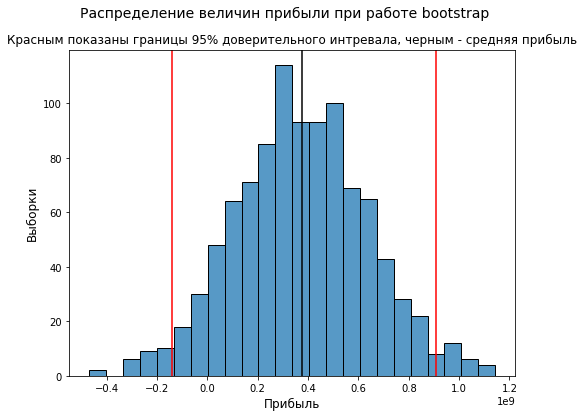

In [101]:
bootstrap (X_val0, 'geo0')

<br/>    
<div class="alert alert-info">

<b></b>Да, после правки ф-ции расчета прибыли результаты серьезно поменялись...
</div> 
<br/>   

По региону  geo1
Средняя прибыль : 443486959.47373486
95% доверительный интервал : 45199968.87372285 - 831069980.7870141
Количество выборок с отрицательной прибылью : 21
Риск убытков fail_earn:  2.1 %
Риск убытков risk_by_scipy:  2.1 %
Риск убытков risk_by_values:  2.1 %


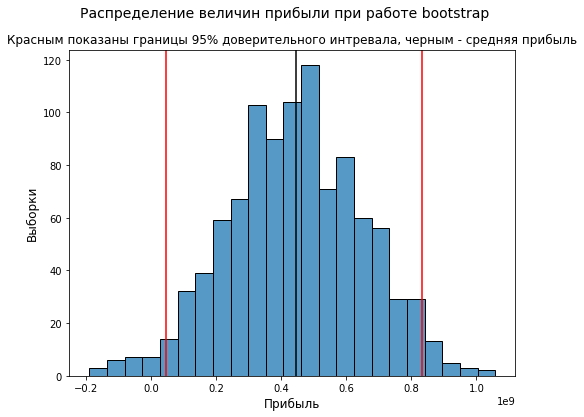

In [102]:
bootstrap (X_val1, 'geo1')

По региону  geo2
Средняя прибыль : 350637096.52734935
95% доверительный интервал : -195137273.5182467 - 828577093.2839098
Количество выборок с отрицательной прибылью : 85
Риск убытков fail_earn:  8.5 %
Риск убытков risk_by_scipy:  8.5 %
Риск убытков risk_by_values:  8.5 %


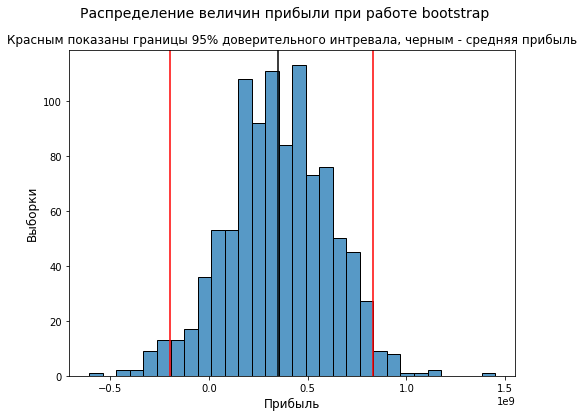

In [103]:
bootstrap (X_val2, 'geo2')

### **Подитог по расчету рисков и прибыли для каждого региона***
С ипользованием техники bootstarp расчититаны стредние прибыли, 95% доверительный интревал прибыли, и риск убытков(риск получить отрицательную прибыль) для лучших 200 точек по предсказанному обьему для всех 3х регионов.
Результаты следующие:

- По региону  geo0
- Средняя прибыль : 374503486.5735052
- 95% доверительный интервал : -141671306.3242771 - 910209513.7536954
- Риск убытков:  7.5 %


- По региону  geo1
- Средняя прибыль : 443486959.47373486
- 95% доверительный интервал : 45199968.87372285 - 831069980.7870141
- Риск убытков: 2.1 %


- По региону  geo2
- Средняя прибыль : 350637096.52734935
- 95% доверительный интервал : -195137273.5182467 - 828577093.2839098
- Риск убытков: 8.5 %


На основе полученных данных только регион geo1 укладывается в уловие задачи с риском убытков 2.1% и прибылью 374млн
Регионы geo0 и geo2 с рисками убытков 7.5 % и 8.5 % соот-но не могу быть приняты к разработке.

## Заключение. Итоговые выводы.

1.  **Загрузка и подготовка данных.**
Исходные данные продоставлены в 3 датасетах df_geo0, df_geo1, df_geo0. Данные без пропусков, типы данных корректны, именование колонок соответствует, датасеты содержат по 100 тыс записей. Датасеты содержат равное количество входных признаков. По не понятным причинам есть дубликаты в колонке id: в geo0 - 10шт и по 4 в остальных.

1.1. Итог по исследовательскому анализу а анализу корреляций

-  `по датасету df_geo0` 
- Параметры f0 и f1 демонстрируют нормальное распределение, подозрений на выбросы нет. 
- Параметр f2 тоже распеределен близко к нормальному, есть значения выходящие за рамки "нормального разброса" 
- Значения целевой функции имеет много модальное распределение, подозрений на выборосы нет.
- Коэфф. кор с целевым признаком f0=0.22, f1=0.25, d2=0.48. 
- Мультиколлинеарность не обнаруживается.

-  `по датасету df_geo1` 
- Параметр f0 распределен бимодально. есть подозрение на выброс.
- Параметр f1 распределен нормально, есть подозрения на выбросы.
- Параметр f2 распределен дискретно кластерно, без подозрений на выбросы
- Целевая функция product выглядит похоже - кластерное распределение, без выбросов. 
- Коэфф. кор с целевым признаком f0=0.63, f1=0.19, d2=0.98. 
- Мультиколлинеарность не обнаруживается.

-  `по датасету df_geo2`
- Параметры f0 и f1 распределены близко к нормальному. есть подозрения на выбросы 
- Параметр f2 распределен нормально, есть подозрения на выбросы.
- Целевая функция product - многомодальное распределение, без выбросов. 
- Коэфф. кор с целевым признаком f0=0.2, f1=0.22, d2=0.44. 
- Мультиколлинеарность не обнаруживается.

Данные гоотовы для разбиения и обучения моделей.

2.	**Обучение и проверка модели для каждого региона**
 
- Для каждого региона был запущен процесс кроссвалидации с подбором гиперпараметров модели и поиска лучшего скалера при помощи инструмента GridSearchCV.
- В результате методом grid_search.best_estimator_.predict предсказаны запасы по регионам, которые добавлены в валидационные выборки.
- Наилучшая качество работы по RMSE на валидационной выбрке показано по региону geo1: 0.88, далее geo0 - 37.81, в конце geo2 c 40.00
- В вилидационные датасеты регионов добавлены данные о прогнозируемых запасах

- _Средний предсказанный запаспо региону geo0: 92.4007244058271_
- _Суммарный предсказанный запас по региону geo0: 2310018.110145678_
- _Суммарный фактический запас по региону geo0: 2308547.155072037_
- _Средний предсказанный запас по региону geo1: 68.74722617608553_
- _Суммарный предсказанный запас по региону geo1: 1718680.6544021382_
- _Суммарный фактический запас по региону geo1: 1718214.549132672_
- _Средний предсказанный запас по региону geo2: 95.02272926228342_
- _Суммарный предсказанный запас по региону geo2: 2375568.2315570856_
- _Суммарный фактический запас по региону geo2: 2370457.778985383_

- Итоговые запасы фактические и предсказанные для всех датасетов сопоставимы.


3.	**Подготовка к расчёту прибыли**

- Определен минимальный запас равный 111.1 для безубыточной разработки в точке из расчета 200 точек на регион при цене единицы product 450000

- средние запасы по точке региона во всех регионах ниже минимального запаса

- Разница между средним запасом по региону geo0 и безубыточным минимальным запасом : -18.709972775876295

- Разница между средним запасом по региону geo0 и безубыточным минимальным запасом : -42.36388493502558

- Разница между средним запасом по региону geo0 и безубыточным минимальным запасом : -16.088381848827694

- Отобраны 200 точек с максимальным запасом превышающим уровень безубыточности в каждом регионе в датасеты X_val0_sorted_best_point, X_val1_sorted_best_point, X_val2_sorted_best_point для geo0, geo1 и geo2 сооответственно.


4.	**Расчёт прибыли по выбранным скважинам и предсказаниям модели** 

- Рассчитаны величины прибыли по каждому региону на основе запасов в лучших точках регионов
- _Расчетная прибыль для лучших 200 точек региона geo0 : 3289885760.867914_
- _Расчетная прибыль для лучших 200 точек региона geo1 : 2415086696.681511_
- _Расчетная прибыль для лучших 200 точек региона geo2 : 2397491232.261406_


5.	**Расчёт рисков убытков и прибыли для каждого региона техникой boostrap**

- С ипользованием техники bootstarp расчититаны средние прибыли, 95% доверительный интревал прибыли, и риск убытков(риск получить отрицательную прибыль) для лучших 200 точек по фактическому обьему для всех 3х регионов. Результаты следующие:

- `По региону geo0`
- _Средняя прибыль : 374503486.5735052_
- _95% доверительный интервал : -141671306.3242771 - 910209513.7536954_
- _Риск убытков: 7.5 %_

- `По региону geo1`
- _Средняя прибыль : 443486959.47373486_
- _95% доверительный интервал : 45199968.87372285 - 831069980.7870141_
- _Риск убытков: 2.1 %_

- `По региону geo2`
- _Средняя прибыль : 350637096.52734935_
- _95% доверительный интервал : -195137273.5182467 - 828577093.2839098_
- _Риск убытков: 8.5 %_


6. **Итоговый вывод**

На основе полученных данных только регион geo1 укладывается в уловие задачи с риском убытков 2.1%. Со средней расчетной прибылью ~374млн.
Регионы geo0 и geo2 с рисками убытков 7.5 % и 8.5 % соот-но не могу быть приняты к разработке.
